In [1]:
import news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy.linalg as LA
import joblib
import random

from dotenv import load_dotenv
from news_nlp.topics_detector.topics_naming import (
    load_prompt_from_yaml,
	infer_llm
)
import os
import json

In [31]:
# Global config
RANDOM_SEED = 31415

# Parameters
MAX_FEATURES = 30_000
N_COMPONENTS = 500
K_VALUES = [10, 15, 20, 30, 40, 50]
N_TOP_TERMS = 10

# Load data

In [3]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

,id_news,title,content,text,len_text
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894
...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093


In [4]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89928

# Vectorization with TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.

## Full-vocabulary vectorization

In [5]:
# TF-IDF Vectorizer configuration
tfidf_full = TfidfVectorizer(
#     ngram_range=(1, 2),      # unigrams and bi-grams
#     stop_words="english",
#     min_df=5,                # at least in 5 documents
#     max_df=0.7               # discards very frequent terms
	max_features=None
)

In [6]:
X_full = tfidf_full.fit_transform(texts)
X_full.shape

(89928, 158998)

In [7]:
vocab_full = tfidf_full.get_feature_names_out()
vocab_full

array(['00', '000', '0000', ..., '晏宏', '温麟衍', 'ﬁle'],
      shape=(158998,), dtype=object)

In [8]:
term_freq = np.asarray(X_full.sum(axis=0)).ravel()
term_freq

array([4.69435942e+01, 5.39258810e+02, 9.05058664e-01, ...,
       4.82312353e-02, 1.67345636e-01, 1.04451748e-01], shape=(158998,))

In [9]:
sorted_idx = np.argsort(-term_freq)
freq_sorted = term_freq[sorted_idx]
vocab_sorted = vocab_full[sorted_idx]
vocab_sorted

array(['the', 'to', 'of', ..., 'deggeller', 'monosodium', 'candymakers'],
      shape=(158998,), dtype=object)

In [10]:
total_freq = freq_sorted.sum()
total_freq

np.float64(793884.1018772459)

In [11]:
coverage = np.cumsum(freq_sorted) / total_freq
coverage

array([0.01685862, 0.02649397, 0.03464927, ..., 0.99999999, 1.        ,
       1.        ], shape=(158998,))

In [12]:
def features_for_coverage(coverage_array, target):
    return int(np.searchsorted(coverage_array, target) + 1)

In [13]:
n_90 = features_for_coverage(coverage, 0.90)
n_95 = features_for_coverage(coverage, 0.95)
n_99 = features_for_coverage(coverage, 0.99)
n_999 = features_for_coverage(coverage, 0.999)
print(f"Number of features to cover 90% of the corpus: {n_90}")
print(f"Number of features to cover 95% of the corpus: {n_95}")
print(f"Number of features to cover 99% of the corpus: {n_99}")
print(f"Number of features to cover 99.9% of the corpus: {n_999}")

Number of features to cover 90% of the corpus: 15488
Number of features to cover 95% of the corpus: 28766
Number of features to cover 99% of the corpus: 76037
Number of features to cover 99.9% of the corpus: 136456


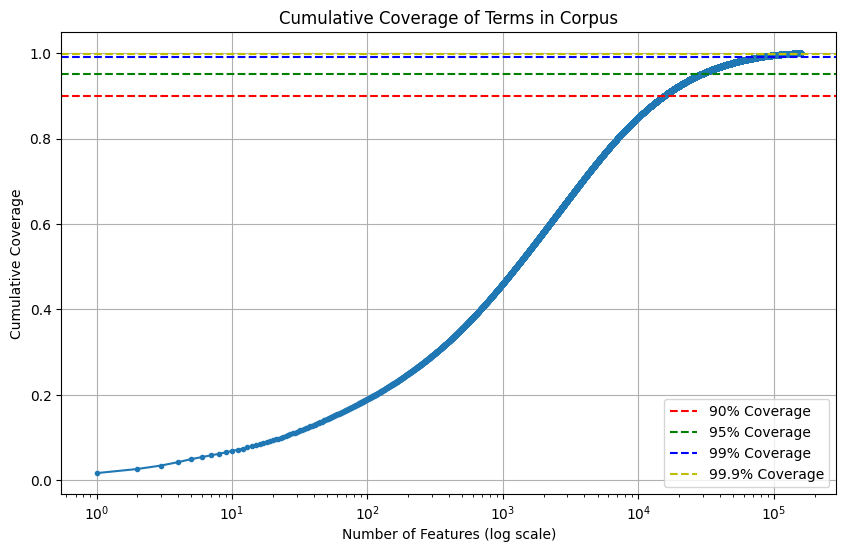

In [14]:
# Plot coverage curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Coverage')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Coverage')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% Coverage')
plt.axhline(y=0.999, color='y', linestyle='--', label='99.9% Coverage')
plt.xscale('log')
plt.xlabel('Number of Features (log scale)')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage of Terms in Corpus')
plt.legend()
plt.grid(True)
plt.show()

## Final vectorizer

In [32]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,  # Limits to top 30k features
    ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
    stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
    min_df=5,                	# Words must appear in at least 5 documents to be included
    max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

In [16]:
# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

(89928, 30000)

In [17]:
# Get feature names (words)
tfidf.get_feature_names_out()

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

# Dimension reduction with Truncated SVD

## Experimentation to find best N_COMPONENTS

In [20]:
"""
Each dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).
Latent topics are linear combinations of the original features that capture underlying themes in the data.
This allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,
which will make subsequent clustering more efficient and potentially more meaningful.
"""

'\nEach dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).\nLatent topics are linear combinations of the original features that capture underlying themes in the data.\nThis allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,\nwhich will make subsequent clustering more efficient and potentially more meaningful.\n'

In [67]:
# n_components = []
# explained_variances = []
for k in range(600, 1001, 100):
    svd = TruncatedSVD(n_components=k, random_state=RANDOM_SEED)
    normalizer = Normalizer(copy=False)
    lsa_pipeline = make_pipeline(svd, normalizer)

    X_lsa = lsa_pipeline.fit(X_tfidf)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    n_components.append(k)
    explained_variances.append(explained_variance)
    
    print(f"Number of components: {k}, Explained variance: {explained_variance:.4f}")

Number of components: 600, Explained variance: 0.2978
Number of components: 700, Explained variance: 0.3201
Number of components: 800, Explained variance: 0.3405
Number of components: 900, Explained variance: 0.3594
Number of components: 1000, Explained variance: 0.3770


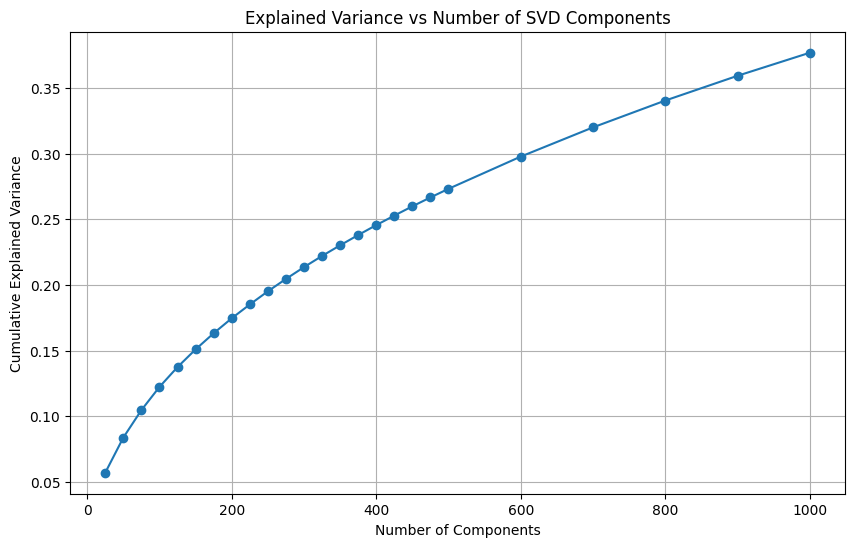

In [68]:
# Plot explained variance vs number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of SVD Components')
plt.grid(True)
plt.show()

## Final TruncatedSVD

Reduce from 30K dimensions to N_COMPONENTS latent components (LSA). This will reduce noise and make clustering faster and more stable.

In [33]:
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_SEED)
svd

,n_components,500
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [34]:
# Noramailzer helps to make distances for K-means more stable
normalizer = Normalizer(copy=False)
normalizer

,norm,'l2'
,copy,False


In [35]:
# Create a pipeline that first applies SVD and then normalizes the result
svd_pipeline = make_pipeline(svd, normalizer)
svd_pipeline

,steps,"[('truncatedsvd', ...), ('normalizer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,500
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [36]:
# Fit and transform the TF-IDF matrix to obtain the reduced representation
X_reduced = svd_pipeline.fit_transform(X_tfidf)
X_reduced.shape

(89928, 500)

In [37]:
explained_var = svd.explained_variance_ratio_.sum()
explained_var

np.float64(0.27326478308297975)

# Clustering with K-Means

In [38]:
"""
Now we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.\n'

In [46]:
def evaluate_k(k_values, X):
    """
    Trains K-means for each k in k_values and computes the silhouette score.
    Args:
        k_values (list): List of k values to evaluate.
        X (array-like): Data to cluster.
    Returns:
        results (list): List of dicts with k and silhouette score.
    """
    results = []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        inertia = km.inertia_
        results.append({"k": k, "silhouette": sil, "inertia": inertia})
        print(f"k={k}, silhouette={sil:.4f}, inertia={inertia:.4f}")
    return results

In [ ]:
results = evaluate_k([10, 15, 20, 30, 40, 50], X_reduced)
df_results = pd.DataFrame(results)
df_results

,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790


In [47]:
results_2 = evaluate_k([60, 70, 80, 90, 100], X_reduced)
df_results_2 = pd.DataFrame(results_2)
df_results = pd.concat([df_results, df_results_2], ignore_index=True)
df_results

k=60, silhouette=0.0490, inertia=69654.5647
k=70, silhouette=0.0542, inertia=68346.7481
k=80, silhouette=0.0593, inertia=67241.3586
k=90, silhouette=0.0633, inertia=66155.8960
k=100, silhouette=0.0653, inertia=65313.7508


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [50]:
results_3 = evaluate_k([150, 200, 250, 300, 400, 500], X_reduced)
df_results_3 = pd.DataFrame(results_3)
df_results = pd.concat([df_results, df_results_3], ignore_index=True)
df_results

k=150, silhouette=0.0787, inertia=61070.3059
k=200, silhouette=0.0895, inertia=57725.9122
k=250, silhouette=0.0983, inertia=55086.2610
k=300, silhouette=0.1042, inertia=53044.2931
k=400, silhouette=0.1060, inertia=50268.0333
k=500, silhouette=0.1035, inertia=48270.5746


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [52]:
results_4 = evaluate_k([325, 350, 375, 425, 450, 475], X_reduced)
df_results_4 = pd.DataFrame(results_4)
df_results = pd.concat([df_results, df_results_4], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=325, silhouette=0.1044, inertia=52301.4346
k=350, silhouette=0.1057, inertia=51545.9716
k=375, silhouette=0.1060, inertia=50843.5771
k=425, silhouette=0.1080, inertia=49547.2217
k=450, silhouette=0.1055, inertia=49157.9553
k=475, silhouette=0.1047, inertia=48733.8044


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [54]:
results_5 = evaluate_k([280, 285, 290, 295, 305, 310, 315, 320], X_reduced)
df_results_5 = pd.DataFrame(results_5)
df_results = pd.concat([df_results, df_results_5], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=280, silhouette=0.1006, inertia=53947.5267
k=285, silhouette=0.1016, inertia=53661.5502
k=290, silhouette=0.1020, inertia=53491.4930
k=295, silhouette=0.1027, inertia=53288.7411
k=305, silhouette=0.1038, inertia=52980.0261
k=310, silhouette=0.1046, inertia=52755.7425
k=315, silhouette=0.1052, inertia=52542.6682
k=320, silhouette=0.1045, inertia=52464.6343


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [56]:
results_6 = evaluate_k([275], X_reduced)
df_results_6 = pd.DataFrame(results_6)
df_results = pd.concat([df_results, df_results_6], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=275, silhouette=0.1013, inertia=54036.6844


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [59]:
df_results_copy = df_results.copy()
df_results.drop(index=[14,15,16,17,19,20,21,22], inplace=True)

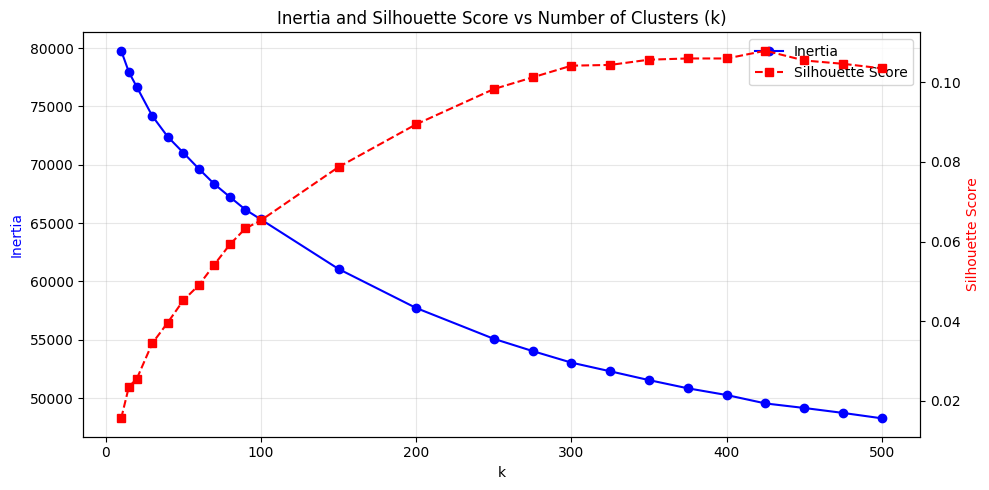

In [60]:
# Plot inertia and silhouette score vs number of clusters (k) with two y-axes
import matplotlib.pyplot as plt

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))

# First axis Y (left)
ax1.plot(df_results["k"], df_results["inertia"], marker="o", color="b", label="Inertia")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia", color="b")
ax1.grid(True, alpha=0.3)

# Second axis Y (right)
ax2 = ax1.twinx()
ax2.plot(df_results["k"], df_results["silhouette"], marker="s", linestyle="--", color="r", label="Silhouette Score")
ax2.set_ylabel("Silhouette Score", color="r")

# Combined legend (from both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Inertia and Silhouette Score vs Number of Clusters (k)")
plt.tight_layout()
plt.show()

In [61]:
"""
The silhouette score reaches an elbow around k=300, which suggests that increasing k further yields diminishing returns in cluster quality.
"""
selected_k = 300

In [62]:
# Train final K-means model with the selected number of clusters
kmeans = KMeans(n_clusters=selected_k, random_state=RANDOM_SEED, n_init="auto")
cluster_labels = kmeans.fit_predict(X_reduced)

df_train["topic_id"] = cluster_labels
df_train[["news_id", "topic_id"]]

KeyError: "['news_id'] not in index"

# Gridsearch for hyperparameters tuning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Define the pipeline for topic modeling
topics_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svd", TruncatedSVD(random_state=42)),
    ("cluster", KMeans(random_state=42))
])

In [ ]:
param_grid = {
    "tfidf__max_features": [30_000, 75_000, 125_000],
	"tfidf__min_df": [3, 5, 10],
	"tfidf__max_df": [0.7, 0.8, 0.9],
	"svd__n_components": [300, 400, 500],
	"cluster__n_clusters": [],
}

In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_scorer(estimator, X, y=None):
    """
    Compute silhouette score on the SVD space using KMeans labels.
    Assumes estimator is a Pipeline: [tfidf -> svd -> cluster].
    """
    # Transform text into reduced space
    X_svd = estimator[:-1].transform(X)
    # Get cluster labels from last step (KMeans)
    labels = estimator[-1].labels_
    
    # For seguridad: si todos los puntos caen en el mismo cluster,
    # silhouette no está definido -> devolvemos algo muy malo.
    if len(set(labels)) < 2:
        return -1.0
    
    return silhouette_score(X_svd, labels)

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=topics_pipeline,
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=3,               # 3 folds para estabilizar un poco
    n_jobs=-1,          # usar todos los cores disponibles
    verbose=2
)

grid_search.fit(X_text)

In [ ]:
print("Best silhouette score:", grid_search.best_score_)
print("Best params:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")

In [ ]:
import pandas as pd

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by="mean_test_score", ascending=False)
results_df.to_csv("gridsearch_topics_results.csv", index=False)

# Inspect topics

In [19]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [20]:
def show_cluster_examples(df, topic_id, n=5):
    """
    Show n example titles from the given cluster_id.
    """
    subset = df[df["topic_id"] == topic_id].sample(n, random_state=RANDOM_SEED)
    for i, row in subset.iterrows():
        print(f"- {row['title']}")

In [21]:
def top_terms_for_cluster(X_tfidf, labels, topic_id, n_terms=15):
    """
    Get the top n_terms with highest average TF-IDF score in the given cluster_id.
    Args:
        X_tfidf (sparse matrix): TF-IDF matrix.
        labels (array-like): Cluster labels for each document.
        topic_id (int): Cluster ID to analyze.
        n_terms (int): Number of top terms to return.
    Returns:
        list: Top n_terms feature names for the cluster.
    """
    idx = np.where(labels == topic_id)[0]
    X_cluster = X_tfidf[idx]
    # suma de tfidf en el cluster
    tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = tfidf_mean.argsort()[::-1][:n_terms]
    return [feature_names[i] for i in top_idx]

In [22]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(selected_k), 5):
    print(f"\n=== CLUSTER {c} ===")
    print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
    show_cluster_examples(df_train, c, n=3)


=== CLUSTER 18 ===
['school', 'schools', 'students', 'teachers', 'parents', 'said', 'children', 'education', 'high school', 'district', 'board', 'high', 'school board', 'teacher', 'student']
- Ron DeSantis Gets Smoked On ‘CBS Sunday’ Over COVID Negligence By Miami School Leader
- Building Easter Island's first music school
- Florida principal crafts personal notes for 459 graduates

=== CLUSTER 25 ===
['game', 'league', 'season', 'team', 'players', 'england', 'games', 'win', 'football', 'said', 'villa', 'club', 'final', 'premier league', 'play']
- 'The first year I arrived I was told we had to win the Champions League'
- Katie Ledecky makes history with first-ever 1,500-meter gold
- Inspired Invincibles crush Brave to win women's Hundred

=== CLUSTER 9 ===
['climate', 'climate change', 'change', 'emissions', 'cop26', 'carbon', 'global', 'warming', 'energy', 'world', 'summit', 'glasgow', 'fossil', 'said', 'biden']
- LSE becomes UK's first carbon-neutral university
- Bill Gates: How the

# Building of topics metadata

In [23]:
# Build a df with a register per topic/cluster
df_topics_meta = (
    df_train
    .groupby("topic_id")
    .agg(size=("news_id", "count"))
    .reset_index()
)

df_topics_meta["top_terms"] = df_topics_meta["topic_id"].apply(
    lambda c: top_terms_for_cluster(X_tfidf, cluster_labels, c, n_terms=N_TOP_TERMS)
)

df_topics_meta

,topic_id,size,top_terms
0,0,3200,"[said, water, storm, weather, people, snow, ca..."
1,1,2050,"[election, voting, georgia, state, voters, vot..."
2,2,3109,"[health, dr, fauci, mask, people, said, patien..."
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s..."
4,4,2980,"[man, police, year old, old, police said, said..."
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,..."
6,6,3810,"[trump, president, donald, donald trump, elect..."
7,7,5430,"[people, like, just, said, know, think, want, ..."
8,8,4084,"[actor, family, prince, said, years, royal, qu..."
9,9,1676,"[climate, climate change, change, emissions, c..."


# Automatic naming of clusters

In [24]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [28]:
system_prompt=load_prompt_from_yaml(paths.PROMPTS_FILE, module="topics_namer")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "titles".\n"terms" contains a list the most relevant words for that cluster, and "titles" contains a list of several news article titles related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and titles provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that cluster.\nD

In [29]:
# Create the user prompt as a JSON object
user_prompt = {int(row["topic_id"]): row["top_terms"] for _, row in df_topics_meta.iterrows()}
user_prompt = json.dumps(user_prompt)
user_prompt

'{"0": ["said", "water", "storm", "weather", "people", "snow", "california", "power", "hurricane", "coast"], "1": ["election", "voting", "georgia", "state", "voters", "vote", "elections", "voter", "trump", "ballots"], "2": ["health", "dr", "fauci", "mask", "people", "said", "patients", "care", "vaccinated", "masks"], "3": ["space", "flight", "nasa", "plane", "crew", "airlines", "spacex", "earth", "passengers", "station"], "4": ["man", "police", "year old", "old", "police said", "said", "year", "shot", "shooting", "chicago"], "5": ["afghanistan", "taliban", "afghan", "kabul", "afghans", "airport", "biden", "withdrawal", "troops", "said"], "6": ["trump", "president", "donald", "donald trump", "election", "house", "impeachment", "president trump", "republican", "capitol"], "7": ["people", "like", "just", "said", "know", "think", "want", "time", "going", "don"], "8": ["actor", "family", "prince", "said", "years", "royal", "queen", "singer", "life", "harry"], "9": ["climate", "climate chang

In [31]:
response = infer_llm(
	model="gpt-5",
    system_prompt=system_prompt,
	prompt=user_prompt,
    api_key=os.getenv("OPENAI_API_KEY", None),
)

In [32]:
# Parse the response JSON
response_json = json.loads(response)
response_json

{'0': 'Severe Weather',
 '1': 'Georgia Elections',
 '2': 'COVID Health Guidance',
 '3': 'Aerospace and Aviation',
 '4': 'Chicago Shootings',
 '5': 'Afghanistan Withdrawal',
 '6': 'Trump Impeachment',
 '7': 'Opinion Commentary',
 '8': 'British Royal Family',
 '9': 'Climate Change',
 '10': 'Criminal Trials',
 '11': 'US Border Policy',
 '12': 'US Congress',
 '13': 'Global Conflicts',
 '14': 'COVID Vaccines',
 '15': 'Social Media Platforms',
 '16': 'Police Shootings',
 '17': 'Activist Post',
 '18': 'Education Policy',
 '19': 'Beauty and Hair',
 '20': 'COVID Variants',
 '21': 'Economic Inflation',
 '22': 'Gun Control',
 '23': 'Capitol Riot',
 '24': 'China and Geopolitics',
 '25': 'Soccer',
 '26': 'CBS News',
 '27': 'Andrew Cuomo',
 '28': 'Brexit',
 '29': 'Campus Politics'}

In [33]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
    [{"topic_id": int(k), "topic_name": v} for k, v in response_json.items()]
)
df_topics_labels

,topic_id,topic_name
0,0,Severe Weather
1,1,Georgia Elections
2,2,COVID Health Guidance
3,3,Aerospace and Aviation
4,4,Chicago Shootings
5,5,Afghanistan Withdrawal
6,6,Trump Impeachment
7,7,Opinion Commentary
8,8,British Royal Family
9,9,Climate Change


In [34]:
# Merge the topic names back into the topics metadata DataFrame
df_topics_meta = df_topics_meta.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Severe Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Aerospace and Aviation
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Shootings
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Opinion Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",British Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [35]:
df_train = df_train.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_train

,news_id,title,content,text,topic_id,topic_name
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Severe Weather
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,US Congress
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Activist Post
...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Opinion Commentary
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,British Royal Family
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Economic Inflation


# Add distance to centroid metric

In [36]:
# Get centroids
centroids = kmeans.cluster_centers_
centroids.shape

(30, 100)

In [37]:
# Calculate distances to centroids
distances = LA.norm(X_reduced - centroids[cluster_labels], axis=1)
distances.shape

(89795,)

In [38]:
# Add distance to centroid metric to df_train
df_train["distance_to_centroid"] = distances
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Severe Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,US Congress,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Activist Post,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Opinion Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,British Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Economic Inflation,0.854098


# Export DataFrames

In [39]:
# Enriched df_train
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Severe Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,US Congress,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Activist Post,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Opinion Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,British Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Economic Inflation,0.854098


In [40]:
# Create a DataFrame with the assignments per news article
assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
df_assignments = df_train[assignments_cols].copy()
df_assignments

,news_id,topic_id,topic_name,distance_to_centroid
0,0,26,CBS News,0.784268
1,1,0,Severe Weather,0.694935
2,2,26,CBS News,0.754938
3,3,12,US Congress,0.653874
4,4,17,Activist Post,0.710781
...,...,...,...,...
89790,89790,7,Opinion Commentary,0.685259
89791,89791,9,Climate Change,0.687143
89792,89792,8,British Royal Family,0.813407
89793,89793,21,Economic Inflation,0.854098


In [41]:
# Metadata about topics
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Severe Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Aerospace and Aviation
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Shootings
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Opinion Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",British Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [42]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics_meta.to_parquet(paths.DF_TOPICS_META, index=False)

# Export models / artifacts

In [43]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)
# Save the models
joblib.dump(tfidf, paths.TFIDF_VECTORIZER)
joblib.dump(svd_pipeline, paths.SVD_MODEL)
joblib.dump(kmeans, paths.KMEANS_MODEL)

['/home/ubuntu/prueba_docker/news-topics-ner/models/topics_detector/kmeans_model.joblib']